# Suprisingly Popular Algorithm on NFL 2017 predictions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from spa import surprisingly_popular, Vote, plurality, weighted_confidence

sns.set(rc={'figure.figsize':(10,5)})

## The Data:

Since we couldn't obtain the original paper ([Prelec, D., Seung, H. & McCoy, J. A solution to the single-question crowd wisdom problem](https://doi.org/10.1038/nature21054)) data, we searched for alternatives datasets that do contain meta-cognitive judgments.

We found two follow-up papers that attempted the evaluate SPA over different domains: 
- [Lee, M.D., Vi, J., & Danileiko, I. (2017), Testing the ability of the surprisingly popular algorithm to predict the 2017 NBA playoffs. Working paper](https://osf.io/hq6a4/).
- [Rutchick, A.M., Ross, B.J., Calvillo, D.P. et al. Does the “surprisingly popular” method yield accurate crowdsourced predictions?. Cogn. Research 5, 57 (2020)](https://doi.org/10.1186/s41235-020-00256-z)

We used the data from both papers. However, since the NBA dataset (Lee et al.) exhibited a consensus among respondents, which was correct (All aggregation methods predicted correctly all games but one), and after further reading about NBA playoffs patterns (which do not contain high variance), we decided to focus on the NFL dataset from Rutchick el al. (Study 1).

The participants (227) were recruited from a psychology course. Each participant was asked to predict the results of the NFL season games (2017).

It's important to point out that the original paper, respondents were asked about questions with a "known" answers, such as state capitals. In this dataset, respondents were asked about future outcomes. A reasonable argue is that these kind of questions usually require higher level of expertise in the subject.

In [2]:
# Preprocessing Helper functions:

def get_nfl_teams_abbr() -> dict:
    """Scrape NFL Teams names from wikipedia to create a mapping between abbrevations and names.

    Returns:
        dict: Mapping between abbrevations and team names.
    """
    link = "https://en.wikipedia.org/wiki/Wikipedia:WikiProject_National_Football_League/National_Football_League_team_abbreviations"

    abbr_df = pd.read_html(link, header=0, index_col='Official Team Abbreviation Codes')[0]
    abbr_df['Franchise'] = abbr_df.Franchise.str.split().str[-1]
    abbr_dict = abbr_df['Franchise'].to_dict()
    common_abbr_dict = abbr_df.set_index('Commonly Used Abbreviations')['Franchise'].to_dict()
    abbr_dict.update(common_abbr_dict)
    return abbr_dict

def replace_prediction(row: pd.Series) -> pd.Series:
    """Replaces the prediction number (1 or 2) of team using the match name.
    Expected match name format is `[Team 1] vs [Team 2]`.

    Args:
        row (pd.Series): A Series containing match predictions (numbers).

    Returns:
        pd.Series: A Series containing match predictions (team names).
    """
    teams = row.name[1].split(' vs ')
    return row.apply(lambda x: teams[x - 1] if pd.notnull(x) else x)

def preprocess_nfl(path: str):
    """Reads NFL csv data file and transform it for further processing.

    Args:
        path (str): Path to csv file.

    Returns:
        NFL predictions pd.DataFrame, Ground-truth pd.Series (games results), fivethirtyeight predictions pd.Series.
    """
    
    nfl_data = pd.read_csv(path, index_col='Participant')

    # Split df to screening question and nfl questions:
    screen_df = nfl_data.iloc[:, :2].drop(labels=['Winner', 'fivethirtyeight']).copy().astype('Int64')
    screen_df.index = screen_df.index.astype(int)
    screen_df.columns = screen_df.columns.str.replace('_', ' ').str.title() # Renaming column names
    screen_df['Knowledge Score'] /= 31 # Score out of 31-questions NFL knowledge questionnarie.
    nfl_df = nfl_data.iloc[:, 2:].copy().astype('Int64')

    # Add Matches Names:
    pat = r"W(\d+)_(\w+)_(\w+)_\w+"
    matches = nfl_df.columns.str.extract(pat)
    matches['Week'] = matches[0].apply("Week {}".format)
    abbr_dict = get_nfl_teams_abbr()
    matches.replace({1 : abbr_dict, 2 : abbr_dict}, inplace=True)
    matches['Match'] = matches[1].str.cat(matches[2], sep=" vs ")
    matches.drop(columns=[0, 1, 2], inplace=True)
    matches['Column'] = ('Prediction', 'Confident', 'Meta-Judment') * int(len(matches) / 3)
    multiindex = pd.MultiIndex.from_frame(matches)
    nfl_df.columns = multiindex

    # Replace prediction with team names:
    nfl_df.loc[:, (slice(None), slice(None), 'Prediction')] = \
        nfl_df.loc[:, (slice(None), slice(None), 'Prediction')].T.apply(replace_prediction, axis=1).T

    nfl_df.loc[:, (slice(None), slice(None), "Meta-Judment")] /= 100 # Between 0 and 1

    winners = nfl_df.loc['Winner', (slice(None), slice(None), 'Prediction')].droplevel(2)
    experts_pred = nfl_df.loc['fivethirtyeight', (slice(None), slice(None), 'Prediction')].droplevel(2)
    nfl_df.drop(labels=['Winner', 'fivethirtyeight'], inplace=True)
    nfl_df.index = nfl_df.index.astype(int)

    return screen_df, nfl_df, winners, experts_pred

In [3]:
# Read 2017 NFL Data:
screen_df, nfl_df, winners, experts_pred = preprocess_nfl('data/NFL_Data_2017.csv')
nfl_df

Week                   Week 1                                         \
Match       Falcons vs Eagles                        Bills vs Ravens   
Column             Prediction Confident Meta-Judment      Prediction   
Participant                                                            
1                      Eagles         4         0.90           Bills   
2                        <NA>      <NA>         <NA>            <NA>   
3                     Falcons         5         0.30           Bills   
4                     Falcons         3         0.50          Ravens   
5                     Falcons         3         0.40           Bills   
...                       ...       ...          ...             ...   
223                      <NA>      <NA>         <NA>            <NA>   
224                    Eagles         3         0.60          Ravens   
225                    Eagles         1         0.30          Ravens   
226                      <NA>      <NA>         <NA>            <NA>   
227                    Eagles         3         0.84          Ravens   

Week                                                                         \
Match                              Jaguars vs Giants                          
Column      Confident Meta-Judment        Prediction Confident Meta-Judment   
Participant                                                                   
1                   2         <NA>           Jaguars         5         0.73   
2                <NA>         <NA>              <NA>      <NA>         <NA>   
3                   4         0.04            Giants         3         <NA>   
4                   4         0.80            Giants         3         <NA>   
5                   3         0.38           Jaguars         4         0.64   
...               ...          ...               ...       ...          ...   
223              <NA>         <NA>              <NA>      <NA>         <NA>   
224                 3         0.59           Jaguars         2         0.41   
225                 2         0.30           Jaguars         1         0.30   
226              <NA>         <NA>              <NA>      <NA>         <NA>   
227                 4         0.95           Jaguars         3         0.70   

Week                              ...           Week 15                       \
Match       Buccaneers vs Saints  ... Seahawks vs 49ers Steelers vs Patriots   
Column                Prediction  ...      Meta-Judment           Prediction   
Participant                       ...                                          
1                         Saints  ...              0.81             Patriots   
2                           <NA>  ...              <NA>             Patriots   
3                         Saints  ...              <NA>             Patriots   
4                     Buccaneers  ...              <NA>                 <NA>   
5                         Saints  ...              0.77             Patriots   
...                          ...  ...               ...                  ...   
223                         <NA>  ...              0.90             Steelers   
224                       Saints  ...              0.99             Steelers   
225                       Saints  ...              <NA>             Steelers   
226                         <NA>  ...              0.88             Steelers   
227                       Saints  ...              0.72             Steelers   

Week                                                                      \
Match                              Rams vs Eagles                          
Column      Confident Meta-Judment     Prediction Confident Meta-Judment   
Participant                                                                
1                   1         <NA>           Rams         6         0.83   
2                   4         <NA>           Rams         5         <NA>   
3                   4         <NA>           Rams         7         <NA>   


## Aggregation Methods:

We've implemented the Suprisingly Popular Algorithm, detailed implmentation is available at `spa.py`.  
Note that our implemntation supports any number of answers, and not just the binary case.

We will compare SPA against two aggregation methods, Plurality (since binary options, Majority) and Confidence-weighted Plurality (using self-reported confidence for each prediciton).

All aggregation results will be compared both to ground-truth (actual game result) and to the predicitons of `FiveThirtyEight` (538), which is an analytical newsletter (sports, politics, etc.), Their predicitons scored `0.62` compared to game results.

### Complete-case (all voters):
First, we will compute our aggregation methods over the entire dataset.

In [4]:
# SPA
spa_correct = []
spa_experts_pred = []
print("=" * 60 )
for week, week_df in nfl_df.groupby(level='Week', axis=1):
    print(f"---------- Calculating SPA for {week} ----------")
    for match, match_df in week_df.groupby(level='Match', axis=1):
        respondants = [Vote(*row) for _, row in match_df.iterrows() if row.notnull().all()]
        pred = surprisingly_popular(respondants, verbose=False)
        score = pred == winners[week, match]
        spa_correct.append(score)
        print(f"{match}: \tSPA is {pred} -> {'Correct' if score else 'Wrong'}!")
        spa_experts_pred.append(pred == experts_pred[week, match])

print("=" * 60 )
spa_acc = sum(spa_correct) / len(spa_correct)
print(f"\nOverall accuracy for SPA: {spa_acc:.3f}")
spa_experts_acc = sum(spa_experts_pred) / len(spa_experts_pred)
print(f"\nOverall accuracy for SPA (vs Experts predictions): {spa_experts_acc:.3f}")

---------- Calculating SPA for Week 1 ----------
49ers vs Vikings: 	SPA is 49ers -> Wrong!
Bears vs Packers: 	SPA is Packers -> Correct!
Bengals vs Colts: 	SPA is Colts -> Wrong!
Bills vs Ravens: 	SPA is Ravens -> Correct!
Buccaneers vs Saints: 	SPA is Saints -> Wrong!
Chiefs vs Chargers: 	SPA is Chargers -> Wrong!
Cowboys vs Panthers: 	SPA is Cowboys -> Wrong!
Falcons vs Eagles: 	SPA is Eagles -> Correct!
Jaguars vs Giants: 	SPA is Giants -> Wrong!
Jets vs Lions: 	SPA is Jets -> Correct!
Rams vs OAK: 	SPA is Rams -> Correct!
Seahawks vs Broncos: 	SPA is Seahawks -> Wrong!
Steelers vs Browns: 	SPA is Steelers -> Correct!
Team vs Cardinals: 	SPA is Cardinals -> Wrong!
Texans vs Patriots: 	SPA is Patriots -> Correct!
Titans vs Dolphins: 	SPA is Dolphins -> Correct!
---------- Calculating SPA for Week 10 ----------
Bills vs Jets: 	SPA is Jets -> Wrong!
Cardinals vs Chiefs: 	SPA is Chiefs -> Correct!
Chargers vs OAK: 	SPA is Chargers -> Correct!
Cowboys vs Eagles: 	SPA is Eagles -> Wrong!


In [5]:
# Plurality
plurality_correct = []
plurarlity_experts_pred = []
print("=" * 60 )
for week, week_df in nfl_df.groupby(level='Week', axis=1):
    print(f"---------- Calculating Plurality for {week} ----------")
    for match, match_df in week_df.groupby(level='Match', axis=1):
        respondants = [Vote(*row) for _, row in match_df.iterrows() if row.notnull().all()]
        pred = plurality(respondants, verbose=False)
        score = pred == winners[week, match]
        plurality_correct.append(score)
        print(f"{match}: \tPlurality answer is {pred} -> {'Correct' if score else 'Wrong'}!")
        plurarlity_experts_pred.append(pred == experts_pred[week, match])

print("=" * 60 )
plurality_acc = sum(plurality_correct) / len(plurality_correct)
print(f"\nOverall Accuracy for Plurality: {plurality_acc:.3f}")
plurality_experts_acc = sum(plurarlity_experts_pred) / len(plurarlity_experts_pred)
print(f"\nOverall accuracy for Plurality (vs Experts predictions): {plurality_experts_acc:.3f}")

---------- Calculating Plurality for Week 1 ----------
49ers vs Vikings: 	Plurality answer is 49ers -> Wrong!
Bears vs Packers: 	Plurality answer is Packers -> Correct!
Bengals vs Colts: 	Plurality answer is Colts -> Wrong!
Bills vs Ravens: 	Plurality answer is Ravens -> Correct!
Buccaneers vs Saints: 	Plurality answer is Saints -> Wrong!
Chiefs vs Chargers: 	Plurality answer is Chargers -> Wrong!
Cowboys vs Panthers: 	Plurality answer is Cowboys -> Wrong!
Falcons vs Eagles: 	Plurality answer is Eagles -> Correct!
Jaguars vs Giants: 	Plurality answer is Giants -> Wrong!
Jets vs Lions: 	Plurality answer is Jets -> Correct!
Rams vs OAK: 	Plurality answer is Rams -> Correct!
Seahawks vs Broncos: 	Plurality answer is Seahawks -> Wrong!
Steelers vs Browns: 	Plurality answer is Steelers -> Correct!
Team vs Cardinals: 	Plurality answer is Cardinals -> Wrong!
Texans vs Patriots: 	Plurality answer is Patriots -> Correct!
Titans vs Dolphins: 	Plurality answer is Dolphins -> Correct!
---------- C

In [6]:
# Weighted-Confidence
w_conf_correct = []
w_conf_experts_pred = []
print("=" * 60 )
for week, week_df in nfl_df.groupby(level='Week', axis=1):
    print(f"---------- Calculating Weighted-Confidence for {week} ----------")
    for match, match_df in week_df.groupby(level='Match', axis=1):
        respondants = [Vote(*row) for _, row in match_df.iterrows() if row.notnull().all()]
        pred = plurality(respondants, verbose=False)
        score = pred == winners[week, match]
        w_conf_correct.append(score)
        print(f"{match}: \tWeighted-Confidence answer is {pred} -> {'Correct' if score else 'Wrong'}!")
        w_conf_experts_pred.append(pred == experts_pred[week, match])


print("=" * 60 )
w_conf_acc = sum(w_conf_correct) / len(w_conf_correct)
print(f"\nOverall accuracy for Weighted-Confidence: {w_conf_acc:.3f}")
w_conf_experts_acc = sum(w_conf_experts_pred) / len(w_conf_experts_pred)
print(f"\nOverall accuracy for Weighted-Confidence (vs Experts predictions): {w_conf_experts_acc:.3f}")

---------- Calculating Weighted-Confidence for Week 1 ----------
49ers vs Vikings: 	Weighted-Confidence answer is 49ers -> Wrong!
Bears vs Packers: 	Weighted-Confidence answer is Packers -> Correct!
Bengals vs Colts: 	Weighted-Confidence answer is Colts -> Wrong!
Bills vs Ravens: 	Weighted-Confidence answer is Ravens -> Correct!
Buccaneers vs Saints: 	Weighted-Confidence answer is Saints -> Wrong!
Chiefs vs Chargers: 	Weighted-Confidence answer is Chargers -> Wrong!
Cowboys vs Panthers: 	Weighted-Confidence answer is Cowboys -> Wrong!
Falcons vs Eagles: 	Weighted-Confidence answer is Eagles -> Correct!
Jaguars vs Giants: 	Weighted-Confidence answer is Giants -> Wrong!
Jets vs Lions: 	Weighted-Confidence answer is Jets -> Correct!
Rams vs OAK: 	Weighted-Confidence answer is Rams -> Correct!
Seahawks vs Broncos: 	Weighted-Confidence answer is Seahawks -> Wrong!
Steelers vs Browns: 	Weighted-Confidence answer is Steelers -> Correct!
Team vs Cardinals: 	Weighted-Confidence answer is Cardin

### Self-reported "Experts" only (High or Very high confidence levels):
Now, we will compute our aggregation methods against a subset of respondents who predict with high, or very high confidence levels (self reported).

In [7]:
# Experts Only - SPA
spa_correct = []
spa_experts_pred = []
print("=" * 60 )
for week, week_df in nfl_df.groupby(level='Week', axis=1):
    print(f"---------- Calculating SPA for {week} ----------")
    for match, match_df in week_df.groupby(level='Match', axis=1):
        match_df = match_df[week, match]
        experts_df = match_df[match_df['Confident'] >= 4]
        respondants = [Vote(*row) for _, row in experts_df.iterrows() if row.notnull().all()]
        pred = surprisingly_popular(respondants, verbose=False)
        score = pred == winners[week, match]
        spa_correct.append(score)
        print(f"{match}: \tSPA is {pred} -> {'Correct' if score else 'Wrong'}!")
        spa_experts_pred.append(pred == experts_pred[week, match])

print("=" * 60 )
experts_spa_acc = sum(spa_correct) / len(spa_correct)
print(f"\nExperts accuracy for SPA: {experts_spa_acc:.3f}")
experts_spa_experts_acc = sum(spa_experts_pred) / len(spa_experts_pred)
print(f"\nExperts accuracy for SPA (vs Experts predictions): {experts_spa_experts_acc:.3f}")

---------- Calculating SPA for Week 1 ----------
49ers vs Vikings: 	SPA is 49ers -> Wrong!
Bears vs Packers: 	SPA is Packers -> Correct!
Bengals vs Colts: 	SPA is Colts -> Wrong!
Bills vs Ravens: 	SPA is Ravens -> Correct!
Buccaneers vs Saints: 	SPA is Saints -> Wrong!
Chiefs vs Chargers: 	SPA is Chargers -> Wrong!
Cowboys vs Panthers: 	SPA is Cowboys -> Wrong!
Falcons vs Eagles: 	SPA is Eagles -> Correct!
Jaguars vs Giants: 	SPA is Giants -> Wrong!
Jets vs Lions: 	SPA is Lions -> Wrong!
Rams vs OAK: 	SPA is Rams -> Correct!
Seahawks vs Broncos: 	SPA is Seahawks -> Wrong!
Steelers vs Browns: 	SPA is Steelers -> Correct!
Team vs Cardinals: 	SPA is Team -> Correct!
Texans vs Patriots: 	SPA is Patriots -> Correct!
Titans vs Dolphins: 	SPA is Dolphins -> Correct!
---------- Calculating SPA for Week 10 ----------
Bills vs Jets: 	SPA is Jets -> Wrong!
Cardinals vs Chiefs: 	SPA is Chiefs -> Correct!
Chargers vs OAK: 	SPA is Chargers -> Correct!
Cowboys vs Eagles: 	SPA is Eagles -> Wrong!
Gian

In [8]:
# Experts Only - Plurality
plurality_correct = []
plurarlity_experts_pred = []
print("=" * 60 )
for week, week_df in nfl_df.groupby(level='Week', axis=1):
    print(f"---------- Calculating Plurality for {week} ----------")
    for match, match_df in week_df.groupby(level='Match', axis=1):
        match_df = match_df[week, match]
        experts_df = match_df[match_df['Confident'] >= 4]
        respondants = [Vote(*row) for _, row in experts_df.iterrows() if row.notnull().all()]
        pred = plurality(respondants, verbose=False)
        score = pred == winners[week, match]
        plurality_correct.append(score)
        print(f"{match}: \tPlurality answer is {pred} -> {'Correct' if score else 'Wrong'}!")
        plurarlity_experts_pred.append(pred == experts_pred[week, match])

print("=" * 60 )
experts_plurality_acc = sum(plurality_correct) / len(plurality_correct)
print(f"\nExperts accuracy for Plurality: {experts_plurality_acc:.3f}")
experts_plurality_experts_acc = sum(plurarlity_experts_pred) / len(plurarlity_experts_pred)
print(f"\nOverall accuracy for Plurality (vs Experts predictions): {experts_plurality_experts_acc:.3f}")

---------- Calculating Plurality for Week 1 ----------
49ers vs Vikings: 	Plurality answer is 49ers -> Wrong!
Bears vs Packers: 	Plurality answer is Packers -> Correct!
Bengals vs Colts: 	Plurality answer is Colts -> Wrong!
Bills vs Ravens: 	Plurality answer is Ravens -> Correct!
Buccaneers vs Saints: 	Plurality answer is Saints -> Wrong!
Chiefs vs Chargers: 	Plurality answer is Chargers -> Wrong!
Cowboys vs Panthers: 	Plurality answer is Cowboys -> Wrong!
Falcons vs Eagles: 	Plurality answer is Eagles -> Correct!
Jaguars vs Giants: 	Plurality answer is Giants -> Wrong!
Jets vs Lions: 	Plurality answer is Jets -> Correct!
Rams vs OAK: 	Plurality answer is Rams -> Correct!
Seahawks vs Broncos: 	Plurality answer is Seahawks -> Wrong!
Steelers vs Browns: 	Plurality answer is Steelers -> Correct!
Team vs Cardinals: 	Plurality answer is Cardinals -> Wrong!
Texans vs Patriots: 	Plurality answer is Patriots -> Correct!
Titans vs Dolphins: 	Plurality answer is Dolphins -> Correct!
---------- C

### Plotting results:

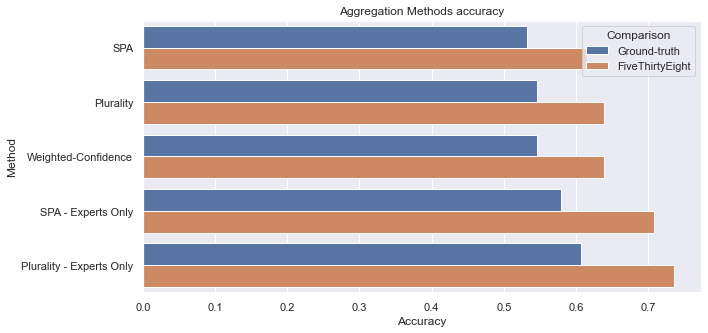

In [9]:
# Results compared to ground truth (games results):
res1 = { "SPA" : spa_acc,
        "Plurality" : plurality_acc,
        "Weighted-Confidence" : w_conf_acc,
        "SPA - Experts Only" : experts_spa_acc,
        "Plurality - Experts Only" : experts_plurality_acc
}

res1_df = pd.DataFrame(res1, index=[1]).melt(var_name='Method', value_name='Accuracy')
res1_df['Comparison'] = 'Ground-truth'

# Results compared to fivethirtyeight (538) predictions:
res2 = { "SPA" : spa_experts_acc,
        "Plurality" : plurality_experts_acc,
        "Weighted-Confidence" : w_conf_experts_acc,
        "SPA - Experts Only" : experts_spa_experts_acc,
        "Plurality - Experts Only" : experts_plurality_experts_acc
}

res2_df = pd.DataFrame(res2, index=[1]).melt(var_name='Method', value_name='Accuracy')
res2_df['Comparison'] = 'FiveThirtyEight'

res_df = pd.concat([res1_df, res2_df])

sns.barplot(data=res_df ,x='Accuracy', y='Method', orient = 'h', hue='Comparison')\
    .set_title("Aggregation Methods accuracy");

We can see that SPA **underperform** Plurality and Weighted-Confidence. However, both SPA and Plurality improved over the "experts" subset.  

### Using Knowledge score:
Since we suspect that "predicting" the future might be a harder task, we were intersted in the performance of SPA over different thresholds of expertise. We will use the knowledge questionnaire score to filter respondents by different thresholds.

In [10]:
score_taus = [x / 100 for x in range(5, 95, 5)]
taus_spa_acc = []
taus_plur_acc = []
taus_sample_size = []
for tau in score_taus:
    filtered_df = nfl_df.loc[screen_df[screen_df['Knowledge Score'] > tau].index].copy()
    taus_sample_size.append(filtered_df.shape[0])
    spa_correct = []
    plur_correct = []
    for week, week_df in filtered_df.groupby(level='Week', axis=1):
        for match, match_df in week_df.groupby(level='Match', axis=1):
            respondants = [Vote(*row) for _, row in match_df.iterrows() if row.notnull().all()]
            spa = surprisingly_popular(respondants, verbose=False)
            spa_correct.append(spa == winners[week, match])
            plur_ans = plurality(respondants, verbose=False)
            plur_correct.append(plur_ans == winners[week, match])

    spa_acc = sum(spa_correct) / len(spa_correct)
    plur_acc = sum(plur_correct) / len(plur_correct)
    print(f"Tau: {tau:.2f}, accuracy for SPA: {spa_acc:.3f}, accuracy for Plurality: {plur_acc:.3f}")
    taus_spa_acc.append(spa_acc)
    taus_plur_acc.append(plur_acc)

Tau: 0.05, accuracy for SPA: 0.542, accuracy for Plurality: 0.551
Tau: 0.10, accuracy for SPA: 0.542, accuracy for Plurality: 0.546
Tau: 0.15, accuracy for SPA: 0.537, accuracy for Plurality: 0.551
Tau: 0.20, accuracy for SPA: 0.551, accuracy for Plurality: 0.551
Tau: 0.25, accuracy for SPA: 0.546, accuracy for Plurality: 0.542
Tau: 0.30, accuracy for SPA: 0.537, accuracy for Plurality: 0.556
Tau: 0.35, accuracy for SPA: 0.560, accuracy for Plurality: 0.556
Tau: 0.40, accuracy for SPA: 0.569, accuracy for Plurality: 0.565
Tau: 0.45, accuracy for SPA: 0.583, accuracy for Plurality: 0.551
Tau: 0.50, accuracy for SPA: 0.574, accuracy for Plurality: 0.574
Tau: 0.55, accuracy for SPA: 0.574, accuracy for Plurality: 0.583
Tau: 0.60, accuracy for SPA: 0.556, accuracy for Plurality: 0.579
Tau: 0.65, accuracy for SPA: 0.588, accuracy for Plurality: 0.597
Tau: 0.70, accuracy for SPA: 0.639, accuracy for Plurality: 0.611
Tau: 0.75, accuracy for SPA: 0.611, accuracy for Plurality: 0.620
Tau: 0.80,

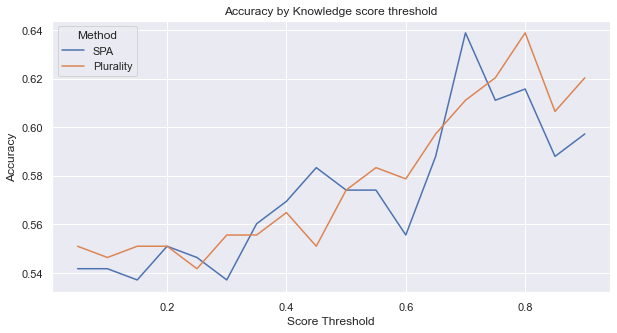

In [11]:
# Plotting methods accuracy as a function of knowledge score threshold:
res_dict = {
    "Score Threshold" : score_taus,
    "SPA" : taus_spa_acc,
    "Plurality" : taus_plur_acc
}

res_df = pd.DataFrame(res_dict).melt(id_vars='Score Threshold', var_name='Method', value_name='Accuracy')

sns.lineplot(data=res_df, x='Score Threshold', y='Accuracy', hue='Method')\
    .set_title('Accuracy by Knowledge score threshold');


We can see that SPA peaks *before* Plurality (around  threshold of `0.7`).  
Note that around a threshold of `0.8` sample size is smaller than 20 respondents!  
This might not be enough for a quality aggregation, and might be affected by local bias.

The important result from this graph is that SPA was able to achieve the same result as Plurality, with *lower* ratio of "experts".  
This means SPA succedeed in "extracting" the correct answer from a noisier data (non-experts).

Another important benefit is that both aggregation methods, were able to "win" `FiveThirtyEight` accuracy score! (`0.62`).

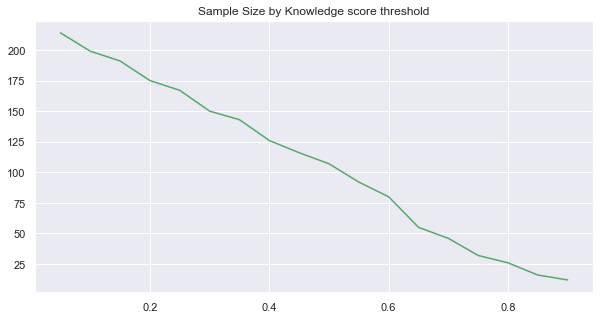

In [12]:
# Plotting Sample size as a function of knowledge score threshold:

sns.lineplot(x=score_taus, y=taus_sample_size, color='g')\
    .set_title('Sample Size by Knowledge score threshold');

## Conclusion:

We couldn't conclude the same succesful result as in the original paper, which showed a significant improvement with SPA.  
However, we were able to find some settings for SPA that have beaten the best prediction of match results we are aware of.  
This means SPA should be further analyzed, with an attempt to extract a *practical* parameters which will maximize the theoretical potential of the aggregation.